# Section 1: Dataset Selection & Cleaning

In [ ]:
from google.colab import drive
import pandas as pd
import json

# Mount Google Drive
drive.mount('/content/drive')

# Load the dataset
file_path = '/content/drive/My Drive/MKA_Advance_NLP/1st_Assignment/IndoNewsCorpus_Dataset/november.json'
with open(file_path, 'r') as f:
    data = json.load(f)

# Convert JSON to DataFrame
df = pd.DataFrame(data)
print(df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
           sumber     tanggal        kategori  \
0  tribunnews.com  2015/11/01  Bisnis Ekonomi   
1  tribunnews.com  2015/11/01  Bisnis Ekonomi   
2  tribunnews.com  2015/11/01  Bisnis Ekonomi   
3  tribunnews.com  2015/11/01  Bisnis Ekonomi   
4  tribunnews.com  2015/11/01  Bisnis Ekonomi   

                                               judul  \
0  Anggota DPR: Kenapa BUMN Diberi Subsidi Rakyat...   
1  DPR Bingung Anggaran Subsidi Listrik Rp 38 Tri...   
2  Jatah Subsidi Listrik Berkurang Picu Kecemburu...   
3  Migrasi Penggunaan Daya Listrik Dinilai Bisa B...   
4  Citi Indonesia Merevolusi Pengalaman Perbankan...   

                                                 isi  \
0  TRIBUNNEWS.COM, JAKARTA - Anggota Komisi VII D...   
1  TRIBUNNEWS.COM, JAKARTA - Anggota Komisi VII D...   
2  TRIBUNNEWS.COM, JAKARTA - Pengamat Ekonomi dar...   
3  TRIBUNNEWS.C

In [ ]:
import re
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')
nltk.download('stopwords')

indonesian_stopwords = set(stopwords.words('indonesian'))

def preprocess_text(text):
    text = text.lower()

    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)      # Remove numbers

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in indonesian_stopwords]

    return ' '.join(tokens)

# Apply preprocessing to the 'isi' column (article content)
df['cleaned_isi'] = df['isi'].apply(preprocess_text)

# Split into training (70%), validation (10%), and test (20%) sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['cleaned_isi'], df['kategori'], test_size=0.3, random_state=42)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=2/3, random_state=42)  # Split remaining 30% into 10% and 20%

print(f"Training set size: {len(train_texts)}")
print(f"Validation set size: {len(val_texts)}")
print(f"Test set size: {len(test_texts)}")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Training set size: 16934
Validation set size: 2419
Test set size: 4839


# Section 2: Methods

## 2.3 LSTM + mBERT


1. Install Required Libraries

In [ ]:
!pip install flair tensorflow==2.12 --quiet

2. Generate mBERT Embeddings

In [ ]:
from flair.embeddings import TransformerDocumentEmbeddings
from flair.data import Sentence
import numpy as np
import torch

torch.set_default_tensor_type('torch.FloatTensor')

mbert_embedding = TransformerDocumentEmbeddings(
    'bert-base-multilingual-cased',
    allow_long_sentences=False  # Disable overlapping windows
)

def generate_flair_embeddings_in_batches(texts, max_len=128, batch_size=32):
    """
    Generate embeddings using Flair in batches with a maximum token length.

    """
    all_embeddings = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]
        sentences = []

        for text in batch_texts:
            text = " ".join(text.split()[:max_len])
            sentences.append(Sentence(text, use_tokenizer=True))
        mbert_embedding.embed(sentences)

        for sentence in sentences:
            all_embeddings.append(sentence.get_embedding().cpu().numpy())

    return np.array(all_embeddings)

X_train_flair = generate_flair_embeddings_in_batches(train_texts, max_len=128, batch_size=32)
X_val_flair = generate_flair_embeddings_in_batches(val_texts, max_len=128, batch_size=32)
X_test_flair = generate_flair_embeddings_in_batches(test_texts, max_len=128, batch_size=32)

print(f"Train embeddings shape: {X_train_flair.shape}")
print(f"Validation embeddings shape: {X_val_flair.shape}")
print(f"Test embeddings shape: {X_test_flair.shape}")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Train embeddings shape: (16934, 768)
Validation embeddings shape: (2419, 768)
Test embeddings shape: (4839, 768)


3. Build and Compile the LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input

X_train_flair = X_train_flair.reshape(X_train_flair.shape[0], 1, X_train_flair.shape[1])

model = Sequential([
    Input(shape=(X_train_flair.shape[1], X_train_flair.shape[2])),
    LSTM(128, return_sequences=True, recurrent_activation='sigmoid'),
    Dropout(0.5),
    LSTM(64, return_sequences=False, recurrent_activation='sigmoid'),
    Dropout(0.5),
    Dense(len(set(train_labels)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 128)            459264    
                                                                 
 dropout_4 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
Total params: 509,192
Trainable params: 509,192
Non-trainable params: 0
_________________________________________________________________
None


4. Train the Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

X_val_flair = X_val_flair.reshape(X_val_flair.shape[0], 1, X_val_flair.shape[1])
X_test_flair = X_test_flair.reshape(X_test_flair.shape[0], 1, X_test_flair.shape[1])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

with tf.device('/device:GPU:0'):
    lstm_mBERT = model.fit(
        X_train_flair,
        train_labels_encoded,
        validation_data=(X_val_flair, val_labels_encoded),
        epochs=10,
        batch_size=32,
        callbacks=[early_stopping]
    )


print(lstm_mBERT.history)

Epoch 1/10
530/530 [==============================] - 8s 8ms/step - loss: 1.0851 - accuracy: 0.6317 - val_loss: 0.7670 - val_accuracy: 0.7032
Epoch 2/10
530/530 [==============================] - 3s 6ms/step - loss: 0.7841 - accuracy: 0.7268 - val_loss: 0.6406 - val_accuracy: 0.7702
Epoch 3/10
530/530 [==============================] - 3s 6ms/step - loss: 0.7046 - accuracy: 0.7553 - val_loss: 0.6359 - val_accuracy: 0.7718
Epoch 4/10
530/530 [==============================] - 3s 6ms/step - loss: 0.6694 - accuracy: 0.7706 - val_loss: 0.5966 - val_accuracy: 0.7908
Epoch 5/10
530/530 [==============================] - 3s 6ms/step - loss: 0.6342 - accuracy: 0.7839 - val_loss: 0.5436 - val_accuracy: 0.8169
Epoch 6/10
530/530 [==============================] - 3s 6ms/step - loss: 0.6109 - accuracy: 0.7909 - val_loss: 0.5410 - val_accuracy: 0.8098
Epoch 7/10
530/530 [==============================] - 3s 6ms/step - loss: 0.5888 - accuracy: 0.7979 - val_loss: 0.5275 - val_accuracy: 0.8173
Epoch 

5. Evaluate the Model on the Test Set

152/152 [==============================] - 1s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.74      0.72       773
           1       0.90      0.97      0.94       686
           2       0.67      0.56      0.61       196
           3       0.87      0.91      0.89      2371
           4       0.93      0.70      0.80       274
           5       0.82      0.55      0.66       154
           6       0.76      0.61      0.68       236
           7       0.72      0.66      0.69       149

    accuracy                           0.83      4839
   macro avg       0.80      0.71      0.75      4839
weighted avg       0.83      0.83      0.83      4839



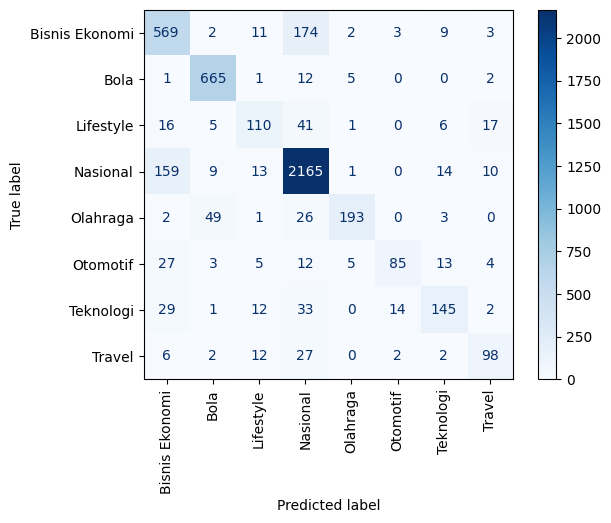

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

test_predictions = model.predict(X_test_flair).argmax(axis=1)

print("Classification Report:")
print(classification_report(test_labels_encoded, test_predictions))

conf_matrix = confusion_matrix(test_labels_encoded, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", xticks_rotation='vertical')